# Dataproject

We start by getting the import and API reader

In [1]:
#!pip install numpy
#!pip install matplotlib
#%pip install git+https://github.com/alemartinello/dstapi
#%pip install fredapi
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# APIs
from fredapi import Fred
from dstapi import DstApi

# 1. Aggregate inflation in Denmark

## 1.1

We start by getting the data from pris113

In [2]:
PRIS113 = DstApi('PRIS113') 
PRIS113.tablesummary(language='en')

params = {
    'table': 'PRIS113',
    'format': 'BULK',       
    'lang': 'en',
    'variables': [
        {'code': 'TYPE', 'values': ['INDEKS']},
        {'code': 'Tid', 'values': ['*']}
    ]
}
df = PRIS113.get_data(params=params)

df.columns = ['TYPE', 'TID', 'INDHOLD']

df['INDHOLD'] = df['INDHOLD'].astype(float)

# Konverter time to numeric datetime
df['TID'] = pd.to_datetime(df['TID'], format='%YM%m')  

Table PRIS113: Consumer price index by type and time
Last update: 2025-10-10T08:00:00


Calculating month to month and year to year, and coverting to pandas format

In [3]:
# converts time to pandas datetime and sorts values
df = df.sort_values('TID')

# makes sure INDHOLD is numeric
df['INDHOLD'] = pd.to_numeric(df['INDHOLD'], errors='coerce')

# index 2020 = 100
avg2020 = df.loc[df['TID'].dt.year == 2020, 'INDHOLD'].mean()
df['INDEX2020'] = df['INDHOLD'] / avg2020 * 100

# calculates month-to-month and year-over-year inflation rates
df['m2m_inflation'] = df['INDEX2020'].pct_change() * 100       # month to month
df['yoy_inflation'] = df['INDEX2020'].pct_change(12) * 100     # 12 months

#using the variable in later comparisons
cpi_denmark = df.copy()

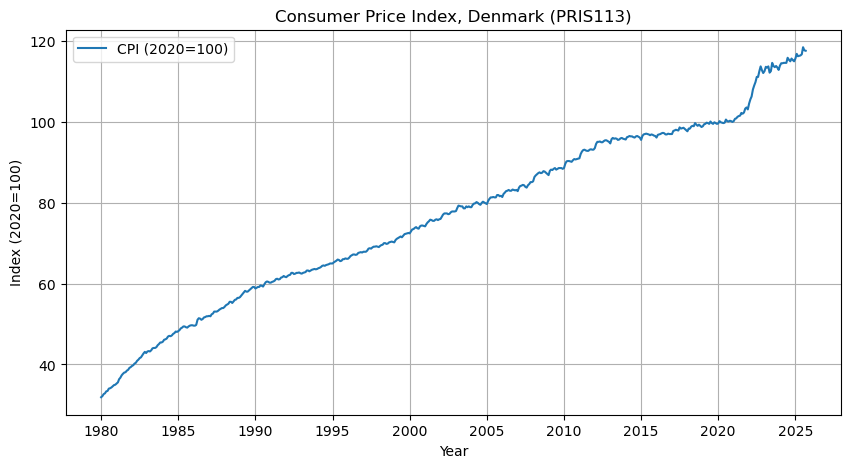

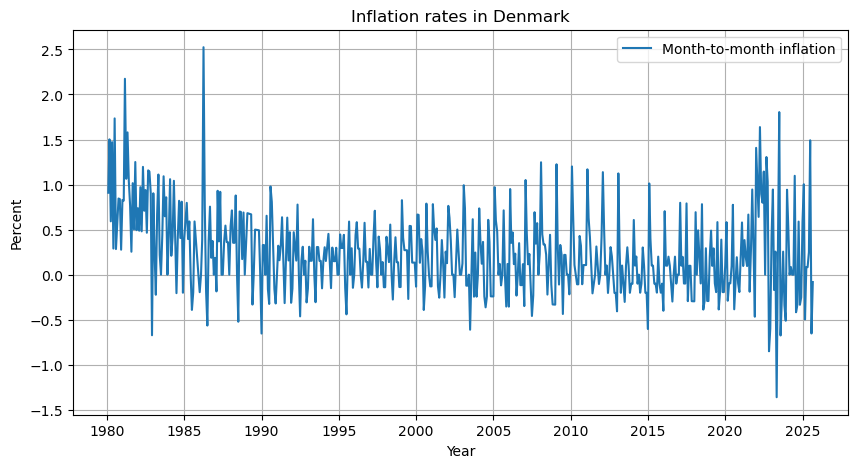

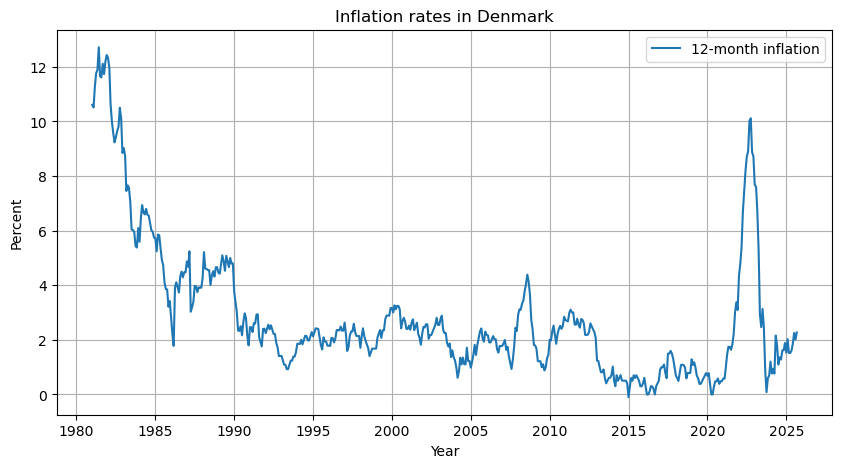

In [4]:
# plotting CPI with 2020 as base year
plt.figure(figsize=(10,5))
plt.plot(df['TID'], df['INDEX2020'], label='CPI (2020=100)')
plt.title('Consumer Price Index, Denmark (PRIS113)')
plt.xlabel('Year')
plt.ylabel('Index (2020=100)')
plt.legend()
plt.grid(True)
plt.show()

# Plotting monthly inflation rates 
plt.figure(figsize=(10,5))
plt.plot(df['TID'], df['m2m_inflation'], label='Month-to-month inflation')
plt.title('Inflation rates in Denmark')
plt.xlabel('Year')
plt.ylabel('Percent')
plt.legend()
plt.grid(True)
plt.show()

# Plotting yearly inflation rates
plt.figure(figsize=(10,5))
plt.plot(df['TID'], df['yoy_inflation'], label='12-month inflation')
plt.title('Inflation rates in Denmark')
plt.xlabel('Year')
plt.ylabel('Percent')
plt.legend()
plt.grid(True)
plt.show()

The post pandemic inflation surge ended in late 2023. The inflation rate came within the inflation target. 

# 1.2 - Instataneous inflation

## 1.2.1


We start by defining k and alpha, and then plotting for alpha values

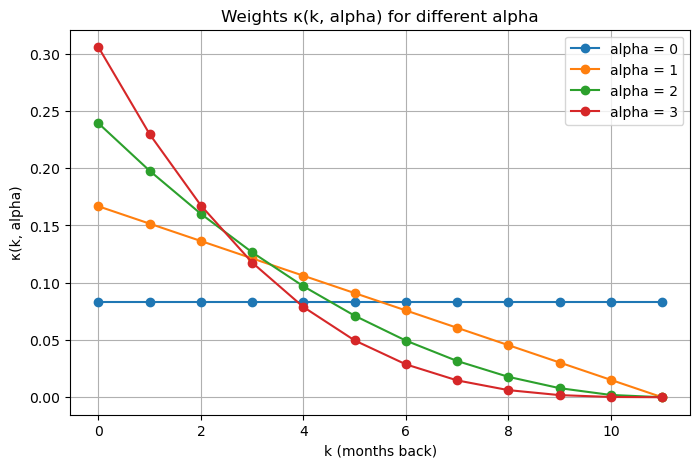

In [5]:
# Defining k and alpha
def kappa(alpha):
    T = 11  # The maximum lag (11 months back)
    ks = np.arange(0, 12)
    weights = (T - ks) ** alpha
    weights = weights / weights.sum()  # normalizing the weights so, that they sum to 1
    return ks, weights

# Plot for α = 0, 1, 2, 3
alphas = [0, 1, 2, 3]
plt.figure(figsize=(8, 5))

for a in alphas:
    ks, w = kappa(a)
    plt.plot(ks, w, marker='o', label=f'alpha = {a}')

plt.xlabel('k (months back)')
plt.ylabel('κ(k, alpha)')
plt.title('Weights κ(k, alpha) for different alpha')
plt.legend()
plt.grid(True)
plt.show()

## 1.2.2

We start by defining the function for instateneous inflation, and then defining the weights

In [6]:
#Defining the function for instantaneous inflation
def instantaneous_over_window(window, alpha):
    # weights
    w = (np.arange(1, 13) ** alpha).astype(float)
    w = w / w.sum()
    return np.prod((1.0 + window) ** w) - 1.0


In [7]:
alphas = [0, 1, 2, 3]

# calculates month-to-month inflation rates
df['m2m_inflation'] = df['INDHOLD'].pct_change() * 100       # month to month

In [8]:
#Defining the weights
def weights(alpha):
    k = np.arange(12)
    T = 11
    w = (T - k)**alpha
    return w / w.sum()

Calculating the instataneous inflation rate

In [9]:
#Calculating the instantaneous inflation rate, Brugt AI
# Define instantaneous inflation calculation 
def inst_inflation_raw(window, alpha):
    vals = np.asarray(window, dtype=float) / 100.0
    if np.isnan(vals).any():
        return np.nan
    w = weights(alpha)[::-1]        # align weights (recent months get more weight)
    return np.exp(np.dot(np.log1p(vals), w)) - 1.0

# Calculate π₁₂,ₐ,ₜ for α = 0, 1, 2, 3
for alpha in [0, 1, 2, 3]:
    df[f"pi_12_alpha_{alpha}"] = (
        df["m2m_inflation"]
          .rolling(window=12, min_periods=12)
          .apply(inst_inflation_raw, raw=True, args=(alpha,))
          * 100
    )


## 1.2.3

Making the graph since 2019

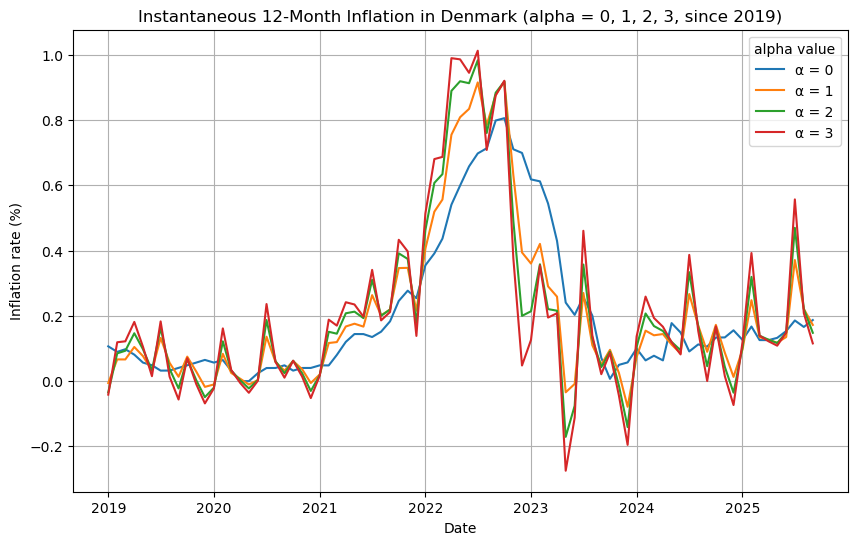

In [10]:
# filter data from 2019 and onward
df_2019 = df[df["TID"] >= "2019-01-01"]

plt.figure(figsize=(10,6))

for alpha in [0, 1, 2, 3]:
    plt.plot(df_2019["TID"], df_2019[f"pi_12_alpha_{alpha}"], label=f"α = {alpha}")

plt.title("Instantaneous 12-Month Inflation in Denmark (alpha = 0, 1, 2, 3, since 2019)")
plt.xlabel("Date")
plt.ylabel("Inflation rate (%)")
plt.legend(title="alpha value")
plt.grid(True)
plt.show()


It can be argued that the instantaneous inflation rate provides a more accurate measure of inflation during volatile periods, such as the pandemic. This approach suggests that the inflation spike ended earlier than indicated by our annualised estimates.

# 1.3 - Core inflation

We start by getting the new dataset PRIS111

In [11]:
#importing data from PRIS111
PRIS111 = DstApi('PRIS111') 

Setting the parameters for the download

In [12]:
params_pris111 = {
    'table': 'PRIS111',
    'format': 'BULK',       
    'lang': 'en',
    'variables': [
        {'code': 'VAREGR', 'values': ['000000', '151000', '141000']},
        {'code': 'ENHED', 'values': ['300']},  # ENHED 300 is the calculated yearly inflation
        {'code': 'Tid', 'values': ['*']}  # selected all time periods
    ]
}
corecpi = PRIS111.get_data(params=params_pris111)

In [13]:
# Replace missing-value marker '..' with NA and convert to numeric (coerce invalid -> NaN)
corecpi['INDHOLD'] = corecpi['INDHOLD'].replace({'..': pd.NA})
corecpi['INDHOLD'] = pd.to_numeric(corecpi['INDHOLD'], errors='coerce')

corecpi['TID'] = pd.to_datetime(corecpi['TID'], format='%YM%m')
corecpi = corecpi.set_index('TID').sort_index()

corecpi = corecpi.drop(columns=['ENHED'])

corecpi= corecpi.replace({
    '00 Consumer price index, total': 'Total CPI', 
    '14.1 Overall Consumer Price Index - excl. energy and unprocessed food (core inflation)': 'CPI ex. food and energy',
    '15.1 Overall Consumer Price Index excl. energy': 'CPI ex. energy'
})

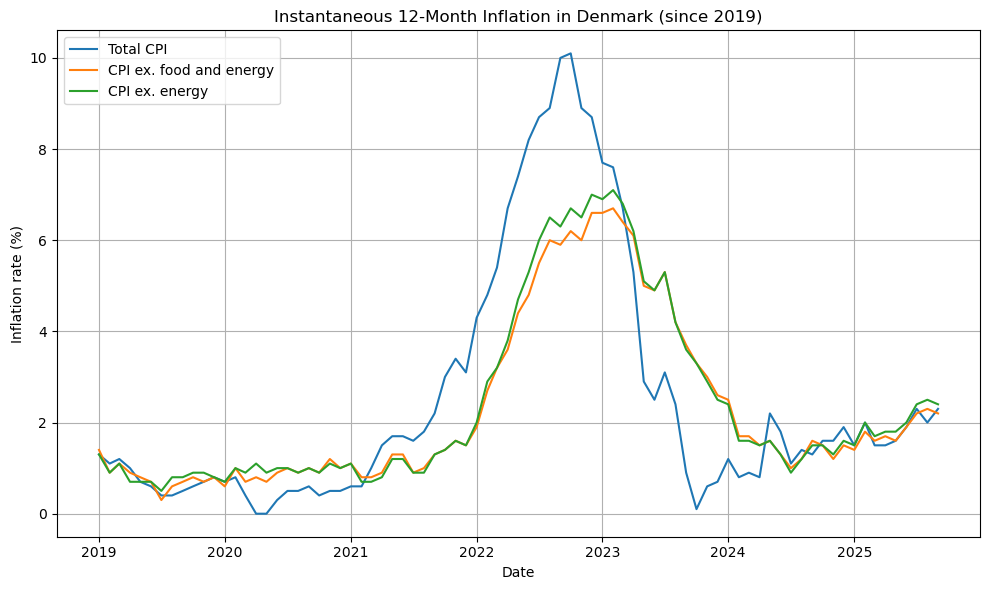

In [14]:

# select the rows with the time period from 2019 onwards
corecpi2019 = corecpi.loc['2019-01-01':]

plt.figure(figsize=(10,6))

# Plot INDHOLD for each VAREGR (use unique groups)
corecpi2019_varegr = corecpi2019['VAREGR'].unique() #forloop over VAREGR
for alpha in corecpi2019_varegr:
    s = corecpi2019[corecpi2019['VAREGR'] == alpha]['INDHOLD']
    plt.plot(s.index, s.values, label=str(alpha))
plt.title("Instantaneous 12-Month Inflation in Denmark (since 2019)")
plt.xlabel("Date")
plt.ylabel("Inflation rate (%)")
plt.legend(title="", loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()

The Danish post‑pandemic inflation surge was primarily driven by external shocks to energy and food prices, while underlying core inflation increased more moderately.

# 1.4 - Disaggregated inflation in Denmark

## 1.4.1

Start by getting an overwiev with the levels commando

In [15]:
levels = DstApi('PRIS111').variable_levels('VAREGR',language='en')

for row in levels.itertuples():
    print(row.id, row.text)



000000 00 Consumer price index, total
010000 01 Food and non-alcoholic beverages
011000 01.1 Food
011100 01.1.1 Bread and cereals
011110 01.1.1.1 Rice
011120 01.1.1.2 Flours and other cereals
011130 01.1.1.3 Bread
011140 01.1.1.4 Other bakery products
011150 01.1.1.5 Pizza and quiche
011160 01.1.1.6 Pasta products and couscous
011170 01.1.1.7 Breakfast cereals
011180 01.1.1.8 Other cereal products
011200 01.1.2 Meat
011210 01.1.2.1 Beef and veal
011220 01.1.2.2 Pork
011230 01.1.2.3 Lamb and goat
011240 01.1.2.4 Poultry
011260 01.1.2.6 Edible offal
011270 01.1.2.7 Dried, salted or smoked meat
011280 01.1.2.8 Other meat preparations
011300 01.1.3 Fish and seafood
011310 01.1.3.1 Fresh or chilled fish
011320 01.1.3.2 Frozen fish
011340 01.1.3.4 Frozen seafood
011350 01.1.3.5 Dried, smoked or salted fish and seafood
011360 01.1.3.6 Other preserved or processed fish and seafood-based preparations
011400 01.1.4 Milk, cheese and eggs
011410 01.1.4.1 Milk, whole, fresh
011420 01.1.4.2 Milk, lo

Making the table with only 4 digit products

In [16]:
four_digit = [(row.id, row.text) for row in levels.itertuples() if str(row.text).count('.') == 3]
# Converting to DataFrame to examine and for accesebility 
four_df = pd.DataFrame(four_digit, columns=["id", "text"])
print({len(four_df)})
display(four_df.head())

{217}


,id,text
0,011110,01.1.1.1 Rice
1,011120,01.1.1.2 Flours and other cereals
2,011130,01.1.1.3 Bread
3,011140,01.1.1.4 Other bakery products
4,011150,01.1.1.5 Pizza and quiche


## 1.4.2

We start by getting the data again in a simpler way, and setting the parameters for the download. We also add code so that it only keeps 4 digit products

In [17]:
PRIS111 = DstApi('PRIS111')
PRIS111.tablesummary(language='en')

params_PRIS111 = {
    'table': 'PRIS111',
    'format': 'BULK',
    'lang': 'en',
    'variables': [
        {'code': 'VAREGR', 'values': ['*']},
        {'code': 'ENHED', 'values': ['100']},
        {'code': 'TID', 'values': ['*']}
    ]
}

PRIS111_data = PRIS111.get_data(params=params_PRIS111)

# Keep only 4-digit VAREGR codes
PRIS111_data = PRIS111_data[PRIS111_data['VAREGR'].str.count(r'\.') == 3].copy()

PRIS111_data.head()


Table PRIS111: Consumer price index by commodity group, unit and time
Last update: 2025-10-10T08:00:00


,VAREGR,ENHED,TID,INDHOLD
0,05.3.2.4 Toasters and grills,Index,2006M07,..
1,05.3.2.9 Other small electric household applia...,Index,2006M07,..
4,"05.4.0.1 Glassware, crystal-ware, ceramic ware...",Index,2006M07,..
5,"05.4.0.2 Cutlery, flatware and silverware",Index,2006M07,..
6,05.4.0.3 Non-electric kitchen utensils and art...,Index,2006M07,..


Converting the columns

In [18]:
# Convert columns
PRIS111_data['INDHOLD'] = pd.to_numeric(PRIS111_data['INDHOLD'], errors='coerce')
PRIS111_data['date'] = pd.to_datetime(PRIS111_data['TID'], format='%YM%m')

In [19]:
#Calculating 12 month inflation rate for each group: 
PRIS111_data = PRIS111_data.sort_values(['VAREGR', 'date'])
PRIS111_data['inflation_12m'] = (
    PRIS111_data.groupby('VAREGR')['INDHOLD'].pct_change(12) * 100)

/var/folders/rp/n7rv5kb51ng5bf6f11x_rzrw0000gn/T/ipykernel_87838/2379148540.py:4: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  PRIS111_data.groupby('VAREGR')['INDHOLD'].pct_change(12) * 100)


Making the figure, with agg plot 

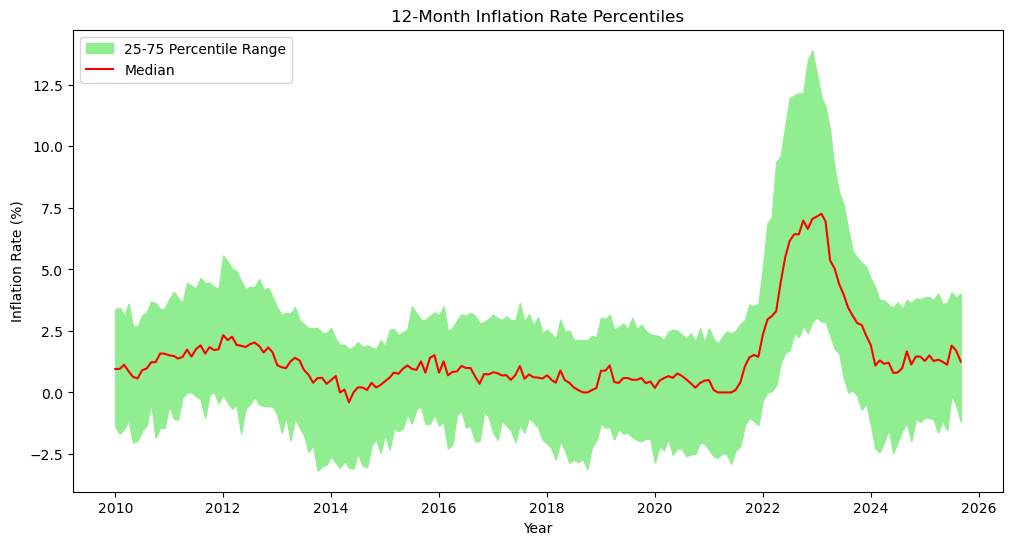

In [20]:
#2. Using agg.plot
percentiles = (
    PRIS111_data
    .groupby('date')['inflation_12m']
    .agg( p25=lambda x: x.quantile(0.25), 
         p50=lambda x: x.quantile(0.50), 
         p75=lambda x: x.quantile(0.75)
    ).reset_index())

percentiles.head()


#plot
plt.figure(figsize=(12, 6))
plt.fill_between(percentiles['date'], percentiles['p25'], percentiles['p75'], color='lightgreen', label='25-75 Percentile Range')
plt.plot(percentiles['date'], percentiles['p50'], color='red', label='Median')
plt.title('12-Month Inflation Rate Percentiles')
plt.xlabel('Year')
plt.ylabel('Inflation Rate (%)')
plt.legend()
plt.show()
plt.rcParams.update({'axes.grid':True,'grid.color':'black','grid.alpha':'0.25','grid.linestyle':'--'})

## 1.4.3

We start by making a subset of the data, that only contains data in the time period

In [21]:
mask = (PRIS111_data["date"] >= "2020-08-01") & (PRIS111_data["date"] <= "2025-08-01")
subset = PRIS111_data.loc[mask]
display(subset.head())


,VAREGR,ENHED,TID,INDHOLD,date,inflation_12m
68285,01.1.1.1 Rice,Index,2020M08,92.4,2020-08-01,0.000000
35473,01.1.1.1 Rice,Index,2020M09,93.2,2020-09-01,0.865801
106366,01.1.1.1 Rice,Index,2020M10,93.5,2020-10-01,1.300108
31247,01.1.1.1 Rice,Index,2020M11,92.6,2020-11-01,1.535088
14690,01.1.1.1 Rice,Index,2020M12,93.5,2020-12-01,3.543743


From here we define the start and end, and from that we calculate the percent change in price

In [22]:
start = subset[subset['date'] == '2020-08-01']
end = subset[subset['date'] == '2025-08-01']

# Renaming the columns for merging
start = start[['VAREGR', 'INDHOLD']].rename(columns={'INDHOLD': 'start_value'})
end = end[['VAREGR', 'INDHOLD']].rename(columns={'INDHOLD': 'end_value'})

#Merging 
price_change = pd.merge(start, end, on='VAREGR', how='inner')
price_change['pct_change'] = ((price_change['end_value'] - price_change['start_value'])
                              / price_change['start_value']) * 100

Now we can make our histogram

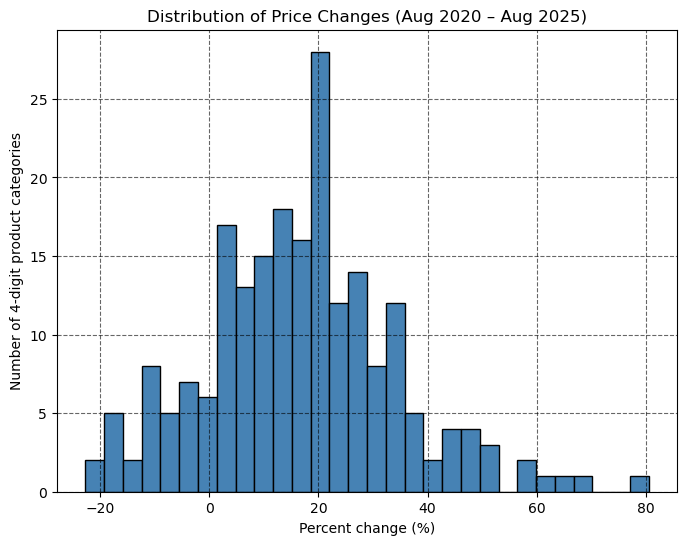

In [23]:
plt.figure(figsize=(8,6))
plt.hist(price_change['pct_change'].dropna(), bins=30, edgecolor='black', color='steelblue')
plt.title('Distribution of Price Changes (Aug 2020 – Aug 2025)')
plt.xlabel('Percent change (%)')
plt.ylabel('Number of 4-digit product categories')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## 1.4.4

We start by finding the top 10 and bottom 10, and then we combine them so we can plot them in one plot

In [24]:
# Sort and select top 10 and bottom 10
top10 = price_change.nlargest(10, 'pct_change')
bottom10 = price_change.nsmallest(10, 'pct_change')

# Combine for plotting
combined = pd.concat([bottom10, top10])
combined = combined.sort_values('pct_change', ascending=True)

Then we make at figure to show it:

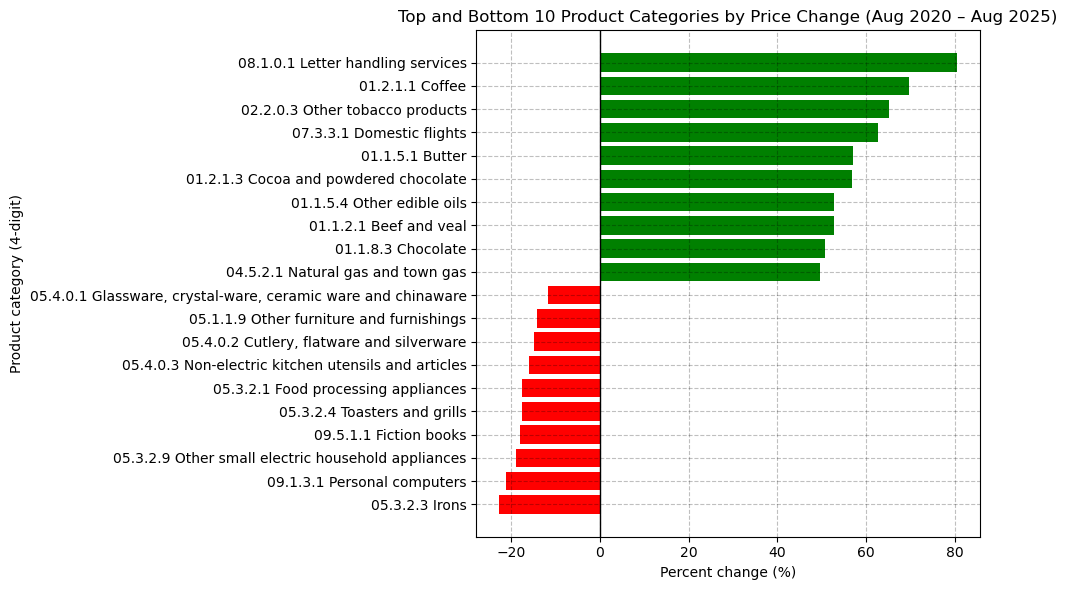

In [25]:
#making the figure
plt.figure(figsize=(10,6))
colors = ['red' if x < 0 else 'green' for x in combined['pct_change']]

plt.barh(combined['VAREGR'], combined['pct_change'], color=colors)
plt.title('Top and Bottom 10 Product Categories by Price Change (Aug 2020 – Aug 2025)')
plt.xlabel('Percent change (%)')
plt.ylabel('Product category (4-digit)')
plt.axvline(0, color='black', linewidth=1)
plt.tight_layout()
plt.show()

# 2 - International comparison

## 2.1

In [26]:
#downloading data from FRED for both exercise 2.1 and 2.2
fred = Fred(api_key='1ab64f652ed49332cee1a585bb660321')

series = {
     "CP0000DKM086NEST": 'Denmark',
     'CP0000ATM086NEST': 'Austria',
     'CP0000EZ19M086NEST': 'Euro Area' ,
     'CPIAUCSL': 'United States' 
}
data = {}
for code, name in series.items():
    var = fred.get_series(code)  
    var.name = name
    data[name] = var
    print(f"Downloaded {code:15s} from FRED and saved it as {name:15s}")

data = pd.DataFrame(data)

Downloaded CP0000DKM086NEST from FRED and saved it as Denmark        
Downloaded CP0000ATM086NEST from FRED and saved it as Austria        
Downloaded CP0000EZ19M086NEST from FRED and saved it as Euro Area      
Downloaded CPIAUCSL        from FRED and saved it as United States  


In [27]:
data.index.name = 'Time'
# index to 2020 = 100
avg_value = data.loc[data.index.year == 2020].mean()
data_indexed = data / avg_value * 100
#selected the timeframe for CPI Denmark to match HICP
cpi_1996 = cpi_denmark.loc[pd.to_datetime(cpi_denmark['TID'])>='1996-01-01']

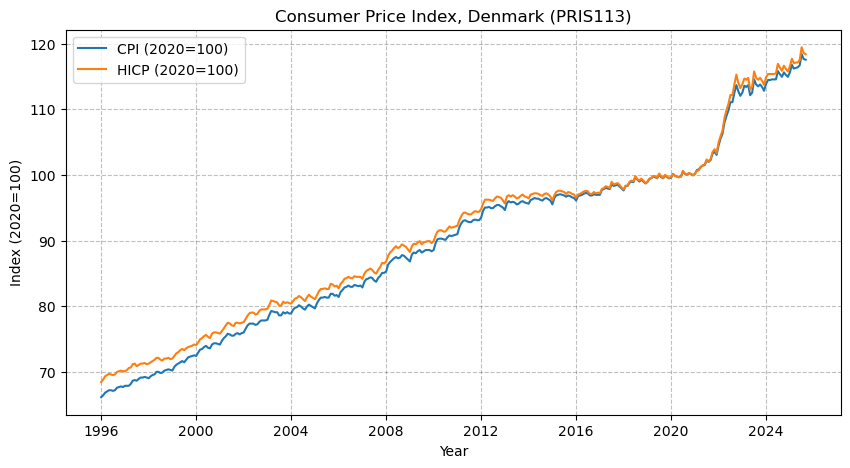

In [28]:
plt.figure(figsize=(10,5))
plt.plot(cpi_1996['TID'], cpi_1996['INDEX2020'], label='CPI (2020=100)')
plt.plot(data_indexed.index, data_indexed['Denmark'], label='HICP (2020=100)')
plt.title('Consumer Price Index, Denmark (PRIS113)')
plt.xlabel('Year')
plt.ylabel('Index (2020=100)')
plt.legend()
plt.grid(True)
plt.show()

HICP is a hormonized index used across EU countries to ensure comparability, while CPI can vary in definition between countries.
HICP excludes certain items like owner-occupied housing costs, which are often included in national CPIs.

## 2.2

In [29]:
# using the manipulated data from 2.1, and therefore don't need to index again
#selecting the data from 2019 and onward
data_indexed_2019 = data_indexed[data_indexed.index >= '2019-01-01']

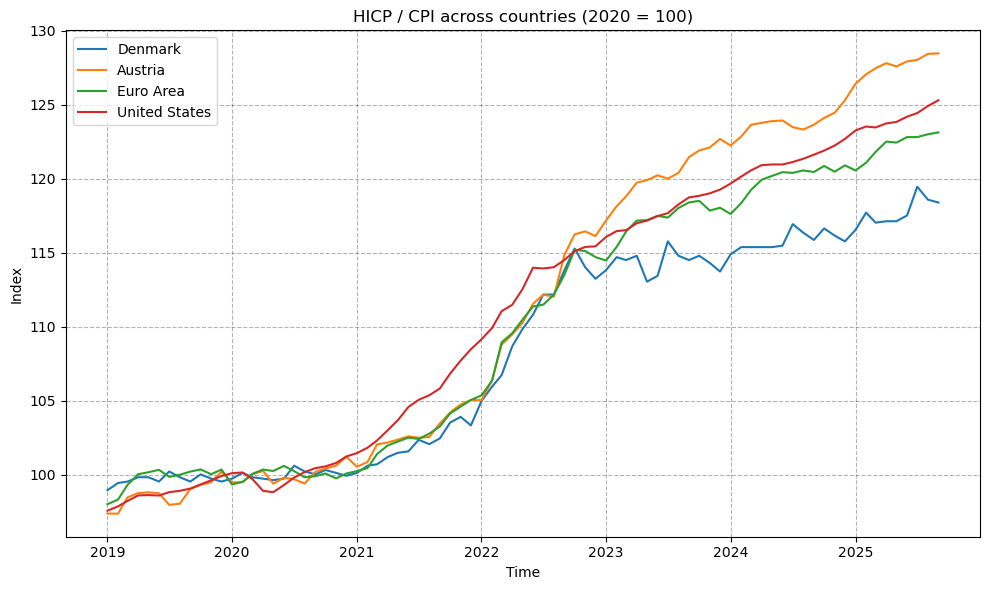

In [30]:
plt.figure(figsize=(10,6))
for col in data_indexed_2019.columns:
    plt.plot(data_indexed_2019.index, data_indexed_2019[col], label=col)
plt.title('HICP / CPI across countries (2020 = 100)')
plt.ylabel('Index')
plt.xlabel('Time')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

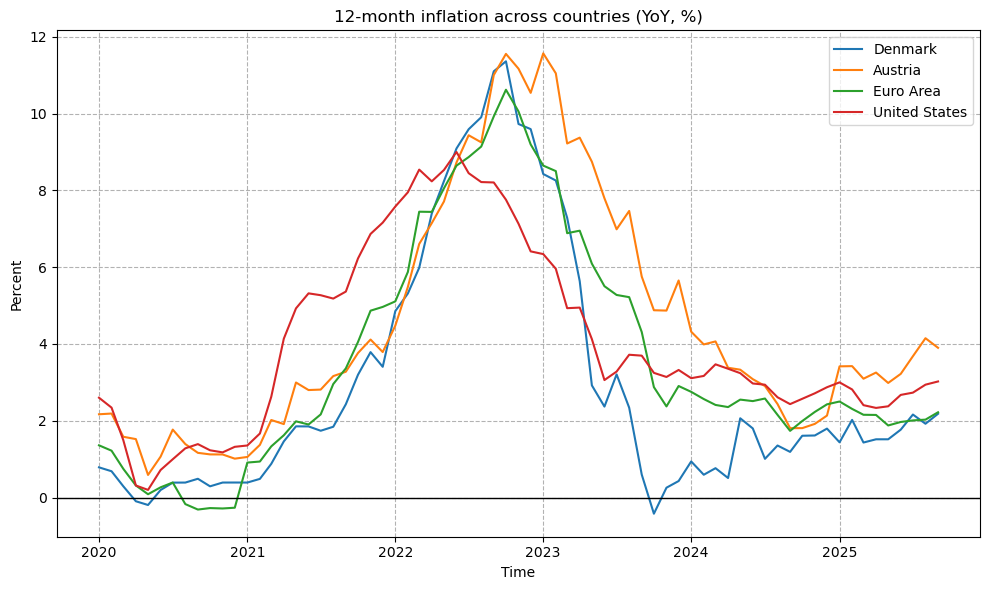

Denmark              Austria              Euro Area               \
         min  mean    max     min  mean    max       min  mean    max   
Time                                                                    
2019     NaN   NaN    NaN     NaN   NaN    NaN       NaN   NaN    NaN   
2020   -0.19  0.33   0.79    0.59  1.39   2.19     -0.31  0.26   1.36   
2021    0.39  1.94   3.79    1.06  2.76   4.11      0.91  2.59   4.96   
2022    4.85  8.51  11.36    4.48  8.59  11.55      5.11  8.36  10.62   
2023   -0.42  3.44   8.43    4.87  7.78  11.57      2.37  5.46   8.64   
2024    0.51  1.27   2.06    1.81  2.93   4.32      1.74  2.36   2.75   
2025    1.43  1.77   2.18    2.98  3.46   4.15      1.88  2.14   2.50   

     United States              
               min  mean   max  
Time                            
2019           NaN   NaN   NaN  
2020          0.20  1.25  2.60  
2021          1.36  4.67  7.16  
2022          6.41  8.00  9.00  
2023          3.06  4.15  6.34  
2024          2.43  2.95  3.47  
2025          2.33  2.70  3.02

In [31]:
# using the downloaded data from FRED
data = data[data.index >= '2019-01-01']
data.index = pd.to_datetime(data.index)

# 1) compute YoY inflation: (Pt / Pt-12 - 1) * 100
infl_12m = data.pct_change(12) * 100

# 2) plotting
plt.figure(figsize=(10,6))
for col in infl_12m.columns:
    plt.plot(infl_12m.index, infl_12m[col], label=col)
plt.title('12-month inflation across countries (YoY, %)')
plt.xlabel('Time'); plt.ylabel('Percent')
plt.axhline(0, lw=1, color='k')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 3) year-by-year min / mean / max for each country
infl_yearly = (
    infl_12m.groupby(infl_12m.index.year)
            .agg(['min','mean','max'])
            .round(2)
)
infl_yearly  # nice table for the report


In [32]:
# min/mean/max since 2019 for each country (rows = countries)
infl_overall = infl_12m.describe().T[['min','mean','max']].round(2)
infl_overall


,min,mean,max
Denmark,-0.42,2.93,11.36
Austria,0.59,4.53,11.57
Euro Area,-0.31,3.59,10.62
United States,0.20,4.01,9.00


In [33]:
# which month had the highest YoY inflation in each country?
peak_month = infl_12m.idxmax()
peak_value = infl_12m.max().round(2)
pd.DataFrame({'Peak month': peak_month, 'Peak YoY %': peak_value})

,Peak month,Peak YoY %
Denmark,2022-10-01,11.36
Austria,2023-01-01,11.57
Euro Area,2022-10-01,10.62
United States,2022-06-01,9.00


The USA inflation surge before the European contries, and was lower than the European contries. The European inflation was higher, a plausible driver for whis could be the rise in energy cost, as we analysed earlier. 

# 3 - Extension

For the extension we will look at the develompent in the wage compared to the CIP index from PRIS113. to do this we will start by getting the wage-data which we will get from SBLON1, which gives us the "Standard beregnet lønindeks"

In [34]:
# Getting the data
SBLON1 = DstApi('SBLON1')
SBLON1.tablesummary(language='en')

# setting the parameters
params_SBLON1 = {
    'table': 'SBLON1',
    'format': 'BULK',
    'lang': 'en',
    'variables': [
        {'code': 'BRANCHE07', 'values': ['TOT']},   
        {'code': 'SEKTOR', 'values': ['1000']},     
        {'code': 'VARIA1', 'values': ['100']},      
        {'code': 'TID', 'values': ['*']}            
    ]
}

SBLON1_data = SBLON1.get_data(params=params_SBLON1)
SBLON1_data.head()

Table SBLON1: Standardised index of average earnings by industry (DB07), sector, unit and time
Last update: 2025-09-01T08:00:00


,BRANCHE07,SEKTOR,VARIA1,TID,INDHOLD
0,"TOT Industry, total",All sectors,Index,2016Q1,98.9
1,"TOT Industry, total",All sectors,Index,2018Q3,104.0
2,"TOT Industry, total",All sectors,Index,2021Q1,109.4
3,"TOT Industry, total",All sectors,Index,2024Q1,119.6
4,"TOT Industry, total",All sectors,Index,2017Q1,100.8


Cleaning and filtering the data, so that we can make the figure

In [35]:
# Convert quarterly codes to datetime (e.g. 2016K1 → 2016Q1 → datetime)
SBLON1_data['TID'] = pd.PeriodIndex(SBLON1_data['TID'], freq='Q').to_timestamp('Q')

# Convert wage index values to numeric
SBLON1_data['INDHOLD'] = pd.to_numeric(SBLON1_data['INDHOLD'], errors='coerce')

#indexing wage index to 2016Q1 = 100
base_q1 = SBLON1_data.loc[SBLON1_data['TID'] == pd.Timestamp('2016-03-31'), 'INDHOLD'].iloc[0]
SBLON1_data['INDHOLD'] = SBLON1_data['INDHOLD'] / base_q1 * 100

# Rename to something clearer
SBLON1_data = SBLON1_data.rename(columns={'INDHOLD': 'Wage_Index'})

# Filter to 2016 and onward
SBLON1_data = SBLON1_data[SBLON1_data['TID'] >= '2016-01-01']

# Average if duplicates exist (e.g., same quarter but different categories)
SBLON1_data = SBLON1_data.groupby('TID', as_index=False)['Wage_Index'].mean()


We already have the pris113 data saved as cpi_denmark, so we will just use that and change the index year and make the data quarterly as well, since the sblon only has qaurterly data

In [36]:

cpi_2016 = cpi_denmark.copy()

cpi_2016 = cpi_2016[cpi_2016['TID'] >= '2016-01-01']
# Rebase CPI index to 2016 = 100 
avg2016 = cpi_2016.loc[cpi_2016['TID'].dt.year == 2016, 'INDHOLD'].mean()
cpi_2016['INDEX2016'] = cpi_2016['INDHOLD'] / avg2016 * 100

# Convert to quarterly averages for comparison with SBLON1
cpi_2016_q = (cpi_2016.set_index('TID')
 .resample('Q')['INDEX2016']
    .mean()
    .reset_index()
    .rename(columns={'INDEX2016': 'Price_Index'})
)
# index first quarter to 100
base_q1_cpi = cpi_2016_q.loc[cpi_2016_q['TID'] == pd.Timestamp('2016-03-31'), 'Price_Index'].iloc[0]
cpi_2016_q['Price_Index'] = cpi_2016_q['Price_Index'] / base_q1_cpi * 100

/var/folders/rp/n7rv5kb51ng5bf6f11x_rzrw0000gn/T/ipykernel_87838/2463722766.py:10: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  .resample('Q')['INDEX2016']


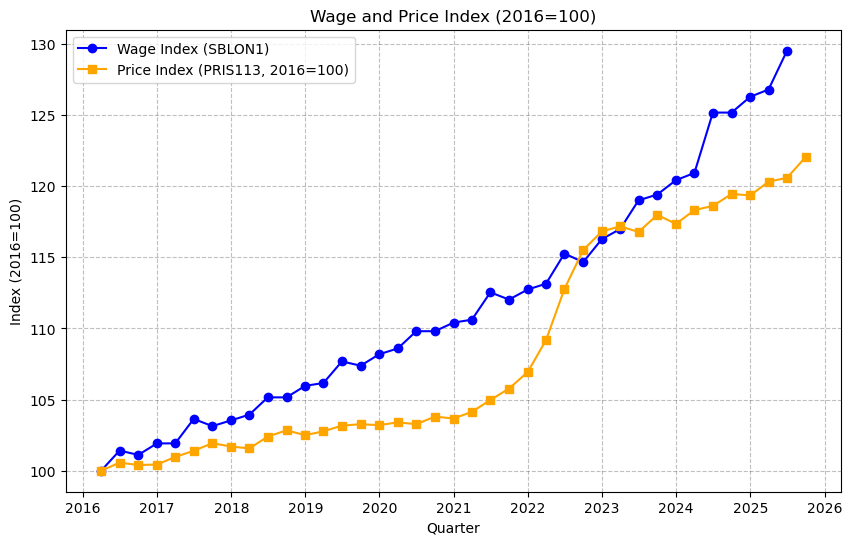

In [37]:
plt.figure(figsize=(10,6))
plt.plot(SBLON1_data['TID'], SBLON1_data['Wage_Index'],
         label='Wage Index (SBLON1)', color='blue', marker='o')
plt.plot(cpi_2016_q['TID'], cpi_2016_q['Price_Index'],
         label='Price Index (PRIS113, 2016=100)', color='orange', marker='s')

plt.title('Wage and Price Index (2016=100)')
plt.xlabel('Quarter')
plt.ylabel('Index (2016=100)')
plt.legend()
plt.grid(True)
plt.show()


Real wages declined during the post‑pandemic inflation surge, as wage growth failed to keep pace with rising prices. In the subsequent period, however, wages have adjusted and have grown at a faster rate than inflation.